In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')

import os, sys, shutil
sys.path.append("..")

from lammpsrun import LAMMPS, Prism
from PBSJobSubmissionScript import PBS_Submitter, qstat_monitor
from utility_scripts import *
import pandas as pd

from ase import Atoms, units
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.io.trajectory import Trajectory
from ase.io import write, read
from ase.build import surface
from ase.spacegroup import crystal, get_spacegroup

cx1_out = r"/rds/general/user/yx6015/home/cx1_out/"
ephemeral = r"/rds/general/user/yx6015/ephemeral/"
sim_path = r"/rds/general/user/yx6015/home/LAMMPS_Simulation/HPC_Jupyter/"
potential = 'ffield.reax.Fe_O_C_H_v2'
print(cx1_out + '\n' + sim_path)

/rds/general/user/yx6015/home/cx1_out/
/rds/general/user/yx6015/home/LAMMPS_Simulation/HPC_Jupyter/


In [ ]:
15.381976    13.281249    16.672292

In [32]:
np.array([13.94, 12.076, 15.846])/np.array([14.04, 12.14, 15.31])

array([0.99287749, 0.99472817, 1.0350098 ])

In [2]:
# Using data from Ehsan
siderite = crystal(symbols = ['Fe', 'C', 'O'],
                    basis = [(0, 0, 0), 
                             (0, 0, 0.25),
                             (0.2741, 0, 0.25)],
                    spacegroup=167,
                    cellpar=[4.676, 4.676, 15.31, 90, 90, 120])

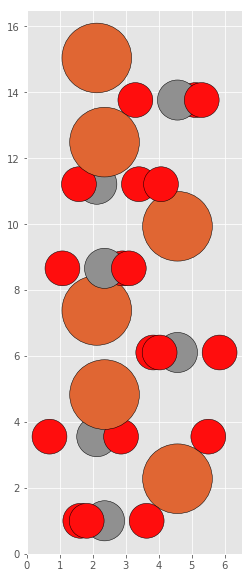

In [3]:
plt.figure(figsize=(18, 10))
plot_atoms(siderite, radii=0.8, rotation=('90x,5y,0z'))
#write("co2_hydration/CO2_solvation.extxyz", CO2_solvation, format = "extxyz")
plt.show()

# Generating Cells for Calculation

In [5]:
from itertools import product
siderite_bulk_trial_sizes = list(product([1, 2, 3, 4, 5], repeat=3))
siderite_bulk_trial_names = ["siderite_bulk_{0}{1}{2}".format(x[0], x[1], x[2]) for x in siderite_bulk_trial_sizes]

In [6]:
siderite_bulk_sizes = []
siderite_bulk_names = []
for sbsize, sbname in zip(siderite_bulk_trial_sizes, siderite_bulk_trial_names):
    siderite_bulk = siderite.repeat(sbsize)
    if not any(siderite_bulk.get_cell_lengths_and_angles() < 10): # Ensuring good minimum cell size. Est ~ 45 different combinations
        
        siderite_bulk_sizes.append(sbsize)
        siderite_bulk_names.append(sbname)
        siderite_bulk_calc = reaxff_params_generator(siderite_bulk, sbname, write_input=True,
                                                     input_fd=os.path.join(sim_path, 'siderite', 'bulk'),
                                                     minimize=["1e-6 1e-6 10000 10000"]*10,
                                                     #min_modify="line quadratic",
                                                     run=1,
                                                     timestep=0.1,
                                                     fix=["box_relax all box/relax aniso 0.0 vmax 1e-4 nreset 10",
                                                          "qeq_reaxc all qeq/reax 1 0.0 10.0 1e-6 reax/c"],
                                                     potential=potential)

In [7]:
siderite_bulk_input = ["{0}.lammpsin".format(x) for x in siderite_bulk_names]
siderite_bulk_commands = ["mpiexec lmp_intel_cpu_intelmpi -sf omp -pk omp 4 -in {0} -screen none\n".format(x) for x in siderite_bulk_input]

siderite_bulk_source_files = [['$HOME/LAMMPS_Simulation/potentials/{0}'.format(potential),
                               '$PBS_O_WORKDIR/'+x+".lammps*"] for x in siderite_bulk_names]

siderite_bulk_PBS = PBS_Submitter(job_names=siderite_bulk_names,
                                  job_commands=siderite_bulk_commands,
                                  modules=["mpi", "lammps/11Aug17", "intel-suite/2017"],
                                  walltime="24:00:00",
                                  proc_nodes=1,
                                  proc_cpus=8,
                                  proc_mpiprocs=2,
                                  proc_threads=4,
                                  memory=16,
                                  source_files=siderite_bulk_source_files)

In [8]:
curr_dir = os.getcwd()
os.chdir(os.path.join(sim_path, 'siderite', 'bulk'))

siderite_bulk_out, siderite_bulkerr = siderite_bulk_PBS.run()

os.chdir(curr_dir)

In [46]:
siderite_bulk_out

['2371379.cx1',
 '2371380.cx1',
 '2371381.cx1',
 '2371382.cx1',
 '2371383.cx1',
 '2371384.cx1',
 '2371385.cx1',
 '2371386.cx1',
 '2371387.cx1',
 '2371388.cx1',
 '2371389.cx1',
 '2371390.cx1',
 '2371391.cx1',
 '2371392.cx1',
 '2371393.cx1',
 '2371394.cx1',
 '2371395.cx1',
 '2371396.cx1',
 '2371397.cx1',
 '2371398.cx1',
 '2371399.cx1',
 '2371400.cx1',
 '2371401.cx1',
 '2371402.cx1',
 '2371403.cx1',
 '2371404.cx1',
 '2371405.cx1',
 '2371406.cx1',
 '2371407.cx1',
 '2371408.cx1',
 '2371409.cx1',
 '2371410.cx1',
 '2371411.cx1',
 '2371412.cx1',
 '2371413.cx1',
 '2371414.cx1',
 '2371415.cx1',
 '2371416.cx1',
 '2371417.cx1',
 '2371418.cx1',
 '2371419.cx1',
 '2371420.cx1',
 '2371421.cx1',
 '2371422.cx1',
 '2371423.cx1']

In [9]:
qstat_monitor()

           JobID        Job Name            User         Runtime          Status           Queue
     2371379.cx1 siderite_bulk_3          yx6015        00:28:42            Done v1_throughput24
     2371380.cx1 siderite_bulk_3          yx6015        00:51:41            Done v1_throughput24
     2371381.cx1 siderite_bulk_3          yx6015        00:33:09            Done v1_throughput24
     2371382.cx1 siderite_bulk_3          yx6015        00:27:49            Done v1_throughput24
     2371383.cx1 siderite_bulk_3          yx6015        00:34:18            Done v1_throughput24
     2371384.cx1 siderite_bulk_3          yx6015        00:27:06            Done v1_throughput24
     2371385.cx1 siderite_bulk_3          yx6015        00:17:12            Done v1_throughput24
     2371386.cx1 siderite_bulk_3          yx6015        00:14:41            Done v1_throughput24
     2371387.cx1 siderite_bulk_3          yx6015        00:26:02            Done v1_throughput24
     2371388.cx1 siderite_bulk

In [10]:
for outfile, job_out in zip(siderite_bulk_names, siderite_bulk_out):
    !mv {sim_path}siderite/bulk/{outfile}.err {ephemeral}{job_out}/
    !mv {sim_path}siderite/bulk/{outfile}.log {ephemeral}{job_out}/

In [11]:
siderite_bulk_valid_names = []
siderite_bulk_valid_out = []

for outfile, job_out in zip(siderite_bulk_names, siderite_bulk_out):
    log_path = os.path.join(ephemeral, job_out, 'log.lammps')
    if os.path.isfile(log_path):
        siderite_bulk_valid_names.append(outfile)
        siderite_bulk_valid_out.append(job_out)

In [ ]:
siderite_bulk_data = []
opt_two_norm = []
stopping_criterion = []
for outfile, job_out in zip(siderite_bulk_valid_names, siderite_bulk_valid_out):
    log_path = os.path.join(ephemeral, job_out, 'log.lammps')

    # As a log file reader for re-runs
    siderite_bulk_calc = LAMMPS()
    
    siderite_bulk_calc.read_lammps_log(lammps_log = log_path)
    siderite_bulk_data.append(pd.DataFrame(siderite_bulk_calc.thermo_content))
    with open(log_path, 'r') as logf:
        lammps_log_content = list(logf)
        lammps_log_content.reverse()
    for line in lammps_log_content:
        if 'Force two-norm initial' in line:
#            opt_data['two-norm'] = float(line.split()[-1])
            opt_two_norm.append(float(line.split()[-1]))
        if 'Stopping criterion' in line:
            stopping_criterion.append((line.split(' = ')[-1]).rstrip())
            break
            
opt_two_norm = np.array(opt_two_norm)
stopping_criterion = np.array(stopping_criterion)

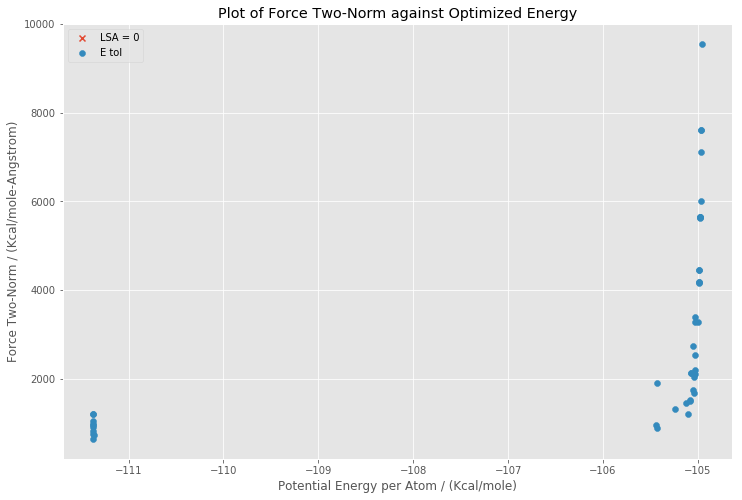

In [18]:
plt.figure(figsize=(12, 8))
atom_final_pe = []

for data in siderite_bulk_data:
    atom_pe = np.array(data['pe'])/np.array(data['atoms'])
    atom_final_pe.append(atom_pe[-1])
atom_final_pe = np.array(atom_final_pe)

plt.scatter(atom_final_pe[stopping_criterion!='energy tolerance'], opt_two_norm[stopping_criterion!='energy tolerance'], marker = 'x', label = 'LSA = 0')
plt.scatter(atom_final_pe[stopping_criterion=='energy tolerance'], opt_two_norm[stopping_criterion=='energy tolerance'], marker = 'o', label = 'E tol')

plt.title("Plot of Force Two-Norm against Optimized Energy")
plt.ylabel("Force Two-Norm / (Kcal/mole-Angstrom)")
plt.xlabel("Potential Energy per Atom / (Kcal/mole)")
plt.legend()
plt.show()

What the above plot tells us that the fact that the energy tolerance is reached still doesn't guarantee an energy minimum. It only really happens when the force two-norm is small enough.

The conversion factor is 69.4786 pN = 1 kcal/mol/A. We are thus looking at a force two-norm of about 50 nN or less. Optimized parameters will be taken from this subset.

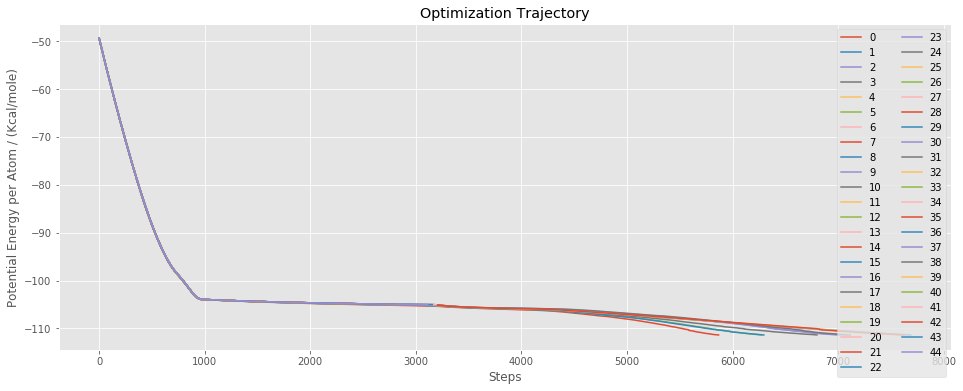

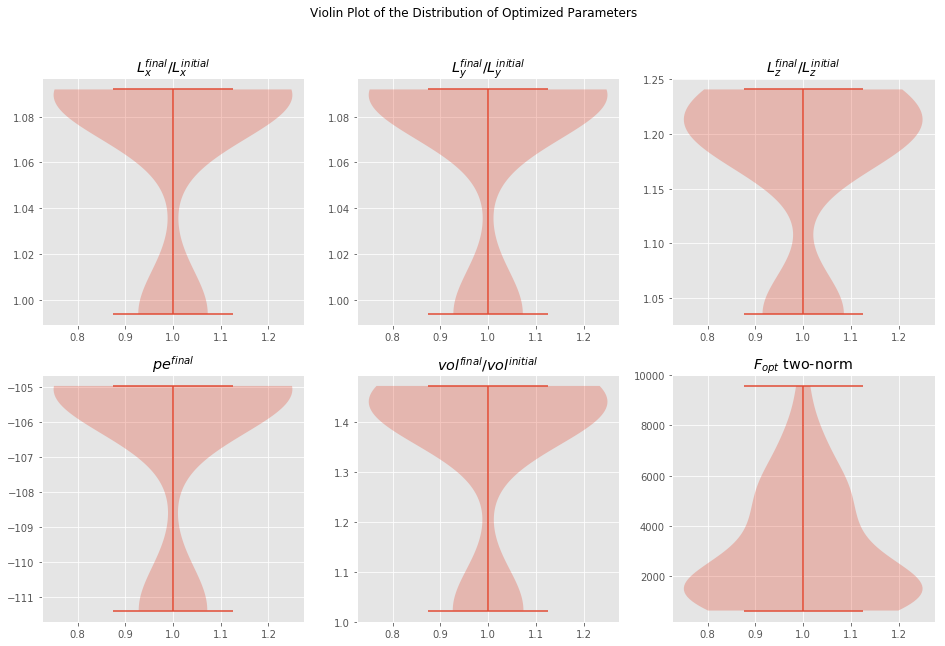

Mean of Ratio Lx:1.068
Mean of Ratio Ly:1.068
Mean of Ratio Lz:1.174
Mean of Ratio Volume:1.348
Mean of Potential Energy per Atom:-106.462


In [21]:
pe_all = []
lx_all = []
ly_all = []
lz_all = []
vol_all = []

plt.figure(figsize=(16, 6))

for i, (data, tol) in enumerate(zip(siderite_bulk_data, stopping_criterion)):
    atom_pe = np.array(data['pe'])/np.array(data['atoms'])
    pe_all.append(atom_pe[-1])
    lx_all.append(data.iloc[-1, 4]/data.iloc[0, 4])
    ly_all.append(data.iloc[-1, 5]/data.iloc[0, 5])
    lz_all.append(data.iloc[-1, 6]/data.iloc[0, 6])
    vol_all.append(data.iloc[-1, -1]/data.iloc[0, -1])
    cur_ls = '--'
    if 'tolerance' in tol:
        cur_ls = '-'
        
    plt.plot(data['step'], atom_pe, label = i, ls = cur_ls)
    
plt.legend(ncol=2)
plt.title("Optimization Trajectory")
plt.ylabel("Potential Energy per Atom / (Kcal/mole)")
plt.xlabel("Steps")
plt.show()

plt.figure(figsize=(16, 10))
plt.suptitle('Violin Plot of the Distribution of Optimized Parameters')
plt.subplot(2, 3, 1)
plt.violinplot(lx_all)
plt.title(r'$L_x^{final}/L_x^{initial}$')
plt.subplot(2, 3, 2)
plt.violinplot(ly_all)
plt.title(r'$L_y^{final}/L_y^{initial}$')
plt.subplot(2, 3, 3)
plt.violinplot(lz_all)
plt.title(r'$L_z^{final}/L_z^{initial}$')
plt.subplot(2, 3, 4)
plt.violinplot(pe_all)
plt.title(r'$pe^{final}$')
plt.subplot(2, 3, 5)
plt.violinplot(vol_all)
plt.title(r'$vol^{final}/vol^{initial}$')
plt.subplot(2, 3, 6)
plt.violinplot(opt_two_norm)
plt.title(r'$F_{opt}$ two-norm')

plt.show()

print("Mean of Ratio Lx:{:.3f}".format(np.mean(lx_all)))
print("Mean of Ratio Ly:{:.3f}".format(np.mean(ly_all)))
print("Mean of Ratio Lz:{:.3f}".format(np.mean(lz_all)))
print("Mean of Ratio Volume:{:.3f}".format(np.mean(vol_all)))
print("Mean of Potential Energy per Atom:{:.3f}".format(np.mean(pe_all)))

# Selecting the correct subset

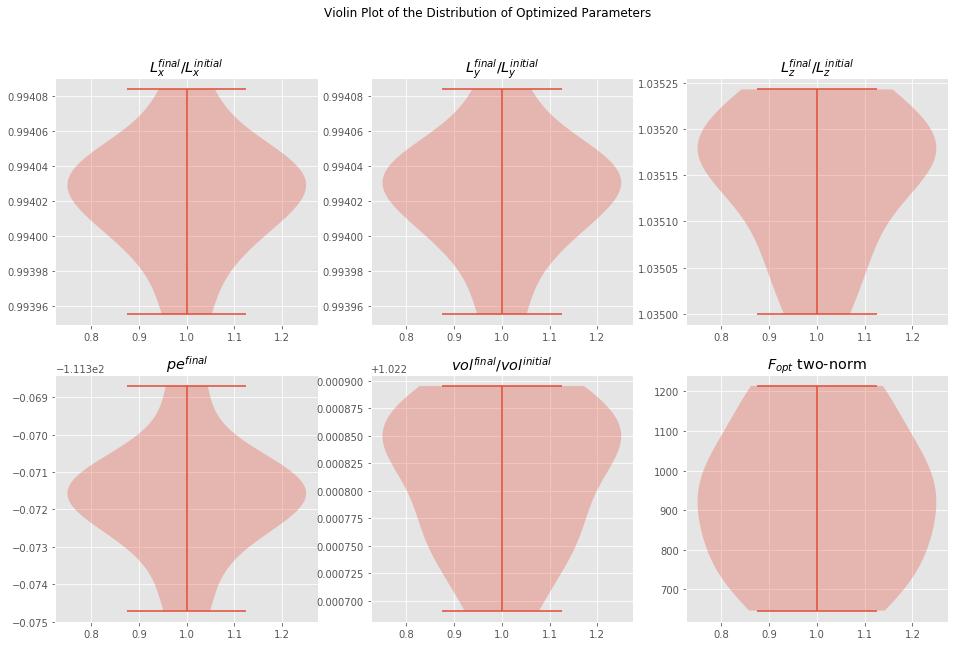

Mean of Ratio Lx:0.9940±0.0000
Mean of Ratio Ly:0.9940±0.0000
Mean of Ratio Lz:1.0351±0.0001
Mean of Ratio Volume:1.0228±0.0001
Mean of Potential Energy per Atom:-111.3717±0.0015


In [44]:
selection_mask = atom_final_pe[stopping_criterion=='energy tolerance'] < -110
plt.figure(figsize=(16, 10))
plt.suptitle('Violin Plot of the Distribution of Optimized Parameters')
plt.subplot(2, 3, 1)
plt.violinplot(np.array(lx_all)[selection_mask])
plt.title(r'$L_x^{final}/L_x^{initial}$')
plt.subplot(2, 3, 2)
plt.violinplot(np.array(ly_all)[selection_mask])
plt.title(r'$L_y^{final}/L_y^{initial}$')
plt.subplot(2, 3, 3)
plt.violinplot(np.array(lz_all)[selection_mask])
plt.title(r'$L_z^{final}/L_z^{initial}$')
plt.subplot(2, 3, 4)
plt.violinplot(np.array(pe_all)[selection_mask])
plt.title(r'$pe^{final}$')
plt.subplot(2, 3, 5)
plt.violinplot(np.array(vol_all)[selection_mask])
plt.title(r'$vol^{final}/vol^{initial}$')
plt.subplot(2, 3, 6)
plt.violinplot(np.array(opt_two_norm)[selection_mask])
plt.title(r'$F_{opt}$ two-norm')

plt.show()


print("Mean of Ratio Lx:{:.4f}±{:.4f}".format(np.mean(np.array(lx_all)[selection_mask]), np.std(np.array(lx_all)[selection_mask])))
print("Mean of Ratio Ly:{:.4f}±{:.4f}".format(np.mean(np.array(ly_all)[selection_mask]), np.std(np.array(ly_all)[selection_mask])))
print("Mean of Ratio Lz:{:.4f}±{:.4f}".format(np.mean(np.array(lz_all)[selection_mask]), np.std(np.array(lz_all)[selection_mask])))
print("Mean of Ratio Volume:{:.4f}±{:.4f}".format(np.mean(np.array(vol_all)[selection_mask]), np.std(np.array(vol_all)[selection_mask])))
print("Mean of Potential Energy per Atom:{:.4f}±{:.4f}".format(np.mean(np.array(pe_all)[selection_mask]), np.std(np.array(pe_all)[selection_mask])))

# Verifying spacegroups

In [ ]:
selected_names = np.array(siderite_bulk_valid_names)[selection_mask]
selected_out = np.array(siderite_bulk_valid_out)[selection_mask]

for outfile, job_out in zip(selected_names, selected_out):
    mol_fd = os.path.join(sim_path, "siderite", "bulk")
    
    trj_path = os.path.join(ephemeral, job_out, outfile+'.lammpstrj')
    ase_traj_path = trj_path[:-10] + '.traj'
    ase_traj = Trajectory(ase_traj_path, 'w')
    mol_path = os.path.join(mol_fd, outfile+".extxyz")
    
    # As a log file reader for re-runs
    traj_reader = LAMMPS()
    traj_reader.set_atoms(read(mol_path))
    traj_reader.trajectory_out = ase_traj
    traj_reader.read_lammps_trj(trj_path)
    ase_traj.close()

In [119]:
selected_names = np.array(siderite_bulk_valid_names)[selection_mask]
selected_out = np.array(siderite_bulk_valid_out)[selection_mask]

for outfile, job_out in zip(selected_names, selected_out):   
    ase_traj_path = os.path.join(ephemeral, job_out, outfile+'.traj')
    sim_traj = Trajectory(ase_traj_path, 'r')
    
    atoms = sim_traj[-1]
    atoms.set_pbc(siderite.get_pbc())
    
    # note that symprec defaults to 0.01 in pymatgen, and 0.1 in materials project
    try:
        sg = get_spacegroup(atoms, symprec=1)
    except Exception:
        pass
    
    print("Surface:", outfile, "\tSpacegroup:", sg.no, sg.symbol)

Surface: siderite_bulk_331 	Spacegroup: 167 R -3 c
Surface: siderite_bulk_332 	Spacegroup: 143 P 3
Surface: siderite_bulk_333 	Spacegroup: 143 P 3
Surface: siderite_bulk_341 	Spacegroup: 167 R -3 c
Surface: siderite_bulk_351 	Spacegroup: 167 R -3 c
Surface: siderite_bulk_431 	Spacegroup: 167 R -3 c
Surface: siderite_bulk_432 	Spacegroup: 1 P 1
Surface: siderite_bulk_451 	Spacegroup: 167 R -3 c
Surface: siderite_bulk_532 	Spacegroup: 1 P 1
Surface: siderite_bulk_541 	Spacegroup: 1 P 1


# Thermal Expansion

In [46]:
np.array([4.64851, 4.64851, 16.606765, 90., 90., 120.])/np.array([4.676, 4.676, 15.31, 90, 90, 120])

array([0.99412104, 0.99412104, 1.08470052, 1.        , 1.        ,
       1.        ])

In [47]:
siderite_upsize = crystal(symbols = ['Fe', 'C', 'O'],
                          basis = [(0, 0, 0), 
                                   (0, 0, 0.25),
                                   (0.2741, 0, 0.25)],
                          spacegroup=167,
                          cellpar=[4.64851, 4.64851, 16.606765, 90., 90., 120.])
                          #cellpar=[4.676*0.993, 4.676*0.993, 15.31*1.085, 90, 90, 120])

siderite_upsize = siderite_upsize.repeat((3, 3, 1))

In [135]:
siderite_te_names = ['siderite_te_5K_1atm']
for ste in siderite_te_names:
    siderite_te_input_dir = os.path.join(sim_path, 'siderite', 'thermal_expansion')
    siderite_te_calc = reaxff_params_generator(siderite_upsize,
                                               job_name=ste,
                                               write_input=True,
                                               input_fd=siderite_te_input_dir,
                                               run=50000,
                                               timestep=0.1,
                                               fix=["fix_npt all npt temp 0.1 5.0 10.0 aniso 1.0 1.0 1000.0",
                                                    "qeq_reaxc all qeq/reax 1 0.0 10.0 1e-6 reax/c"],
                                               potential=potential,
                                               velocity=["all create 0.1 1050027 dist gaussian mom yes rot yes"])

In [136]:
siderite_te_input = ["{0}.lammpsin".format(x) for x in siderite_te_names]
siderite_te_commands = ["mpiexec lmp_intel_cpu_intelmpi -sf omp -pk omp 4 -in {0} -screen none\n".format(x) for x in siderite_te_input]

siderite_te_source_files = [['$HOME/LAMMPS_Simulation/potentials/{0}'.format(potential),
                               '$PBS_O_WORKDIR/'+x+".lammps*"] for x in siderite_te_names]

siderite_te_PBS = PBS_Submitter(job_names=siderite_te_names,
                                job_commands=siderite_te_commands,
                                modules=["mpi", "lammps/11Aug17", "intel-suite/2017"],
                                walltime="24:00:00",
                                proc_nodes=1,
                                proc_cpus=8,
                                proc_mpiprocs=2,
                                proc_threads=4,
                                memory=60,
                                source_files=siderite_te_source_files)

In [137]:
curr_dir = os.getcwd()
os.chdir(siderite_te_input_dir)

siderite_te_out, siderite_te_err = siderite_te_PBS.run()

os.chdir(curr_dir)

In [138]:
qstat_monitor()

           JobID        Job Name            User         Runtime          Status           Queue
     2388290.cx1 siderite_te_5K_          yx6015        01:32:00            Done v1_throughput24
